In [1]:
from openai import OpenAI
import pandas as pd
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from functools import lru_cache
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import hashlib

In [2]:
client = OpenAI()
@lru_cache(maxsize=None)
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [10]:
# Cache embeddings to save $$, remember to clear this to get an accurate time measurement for semantic routing.
# In practice a new input would not have a cached embedding.
hash_to_embeddings = {}

In [11]:
def question_set_to_df(question_sets: list)-> pd.DataFrame:
    dataset = []

    for question_set in question_sets:
        expected_tool = question_set["expected_tool"]
        for question in question_set["questions"]:
            embedding = get_embedding(question)
            dataset.append([question, embedding, expected_tool])
    
    dataframe = pd.DataFrame(dataset, columns = ["question", "embedding", "expected_tool"])
    return dataframe

In [12]:
def visualize_semantic_similarity(frame: pd.DataFrame, plot_title: str = "Semantic Similarity of Questions"):
    # Load the embeddings
    df = frame
    matrix = np.array(df.embedding.to_list())
    tsne = TSNE(n_components=2, perplexity=3, random_state=42, init='random', learning_rate=200)
    vis_dims = tsne.fit_transform(matrix)
    vis_dims.shape

    # Add the coordinates to the dataframe
    df['x'] = vis_dims[:, 0]
    df['y'] = vis_dims[:, 1]
    df.head()

    # Visualize the embeddings
    sns.scatterplot(data=df, x='x', y='y', hue='expected_tool', legend='full', palette='bright')
    plt.title(plot_title)
    plt.show()

In [13]:
def dataframe_hash(df):
    return hashlib.sha256(pd.util.hash_pandas_object(df['question']).values).hexdigest()

# Going to cache the kmeans model to save some time
@lru_cache(maxsize=None)
def memoized_kmeans(embeddings_hash, k):
    embeddings = hash_to_embeddings[embeddings_hash]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    return kmeans

def fit_and_compute_silhouette_score(frame: pd.DataFrame, k: int):

    embeddings = np.array(frame['embedding'].to_list())
    embeddings_hash = dataframe_hash(frame)
    hash_to_embeddings[embeddings_hash] = embeddings

    kmeans = memoized_kmeans(embeddings_hash, k)
    return silhouette_score(embeddings, kmeans.labels_, metric="euclidean")

from sklearn.metrics import davies_bouldin_score

def fit_and_compute_davies_bouldin_score(frame: pd.DataFrame, k: int):
    # Convert the 'embedding' column of the DataFrame to a NumPy array
    embeddings = np.array(frame['embedding'].to_list())
    
    # Optionally, you can cache embeddings using a hash like in the reference function
    embeddings_hash = dataframe_hash(frame)
    hash_to_embeddings[embeddings_hash] = embeddings

    # Get the KMeans clustering model (assuming memoized_kmeans is a function that
    # handles caching of KMeans models based on the embeddings hash and k)
    kmeans = memoized_kmeans(embeddings_hash, k)

    # Compute the Davies-Bouldin score
    return davies_bouldin_score(embeddings, kmeans.labels_)


In [14]:
question_sets = [
    {
        'expected_tool': 'cooking',
        'questions': [
            'What is the best way to cook a steak?',
            'How can I make a delicious stew?',
            'What is the role of tomatoes in stew?',
            'I want to a make a dish to use up lots of black beans, how can I do this?',
            'How can I make a steak medium rare?',
            'How can I make a steak medium rare without a thermometer?',
            "What is the best way to store fresh herbs to prolong their shelf life?",
            "How can you tell if eggs are still fresh?",
            "What's the difference between baking powder and baking soda in recipes?",
            "How do you properly season a cast iron skillet?",
            "What's the secret to making fluffy pancakes?",
            "How can I prevent pasta from sticking together while cooking?",
            "How do you know when a steak is cooked to medium-rare?",
            "What are some effective ways to tenderize tough cuts of meat?",
            "How can you make a perfect emulsion for homemade mayonnaise?",
            "What is the difference between chopping and dicing in cooking?",
            "How do you prevent onions from making you cry while cutting them?",
            "What's the best way to cook rice so it doesn't become mushy?",
            "How do you test the freshness of fish at the market?",
            "What is the purpose of resting meat after cooking?",
            "How can you thicken a sauce without altering its flavor?",
            "What are the key spices in a traditional Indian curry?",
            "What's the difference between simmering and boiling in cooking?",
        ]
    },
    {
        'expected_tool': 'baking',
        'questions': [
            "What are the basic ingredients in baking?",
            "How do you make a perfect sponge cake?",
            "What is the difference between baking soda and baking powder?",
            "How does altitude affect baking?",
            "What are some gluten-free baking tips?",
            "How do you decorate a cake with icing?",
            "What are the secrets to flaky pie crusts?",
            "How can you prevent cookies from spreading too much?",
            "What are the different types of bread dough?",
            "How do you make vegan baked goods?",
            "What is the importance of oven temperature in baking?",
            "How do you make a chocolate soufflé?",
            "What are the best tools for a home baker?",
            "How can you make pastries like a professional?",
            "What are some common baking mistakes and how to avoid them?",
            "How do you bake with alternative sweeteners?",
            "What are some tips for baking with yeast?",
            "How do you create a layered cake?",
            "What are the healthiest baking ingredients?",
            "How do you make homemade pizza dough?",
            "What is the function of eggs in baking recipes?",
            "How do you properly measure flour for consistent results?",
            "What's the difference between unsalted and salted butter in baking?",
            "How can you tell when bread dough has been kneaded enough?",
            "What are some common substitutes for sugar in baking?",
            "How do you prevent a cake from sticking to the pan?",
            "What's the ideal temperature for proofing yeast dough?",
            "How can you achieve a flaky crust in pies?",
            "What is the purpose of sifting flour and other dry ingredients?",
            "How do you create a steamy environment for baking artisan bread?",
            "What are the keys to successful macaron making?",
            "How can you prevent cookies from spreading too much while baking?",
            "What's the best way to melt chocolate for baking?",
            "How do you adjust baking times for different pan sizes?",
            "What causes a cake to rise unevenly in the oven?",
            "How can you tell if a cheesecake is done without overbaking it?",
            "What are some tips for making gluten-free baked goods?",
            "How do you maintain consistent oven temperature for even baking?",
            "What's the difference between baking soda and baking powder in cookies?",
            "How can you create a shiny crust on bread without using egg wash?"
        ]
    },
    {
        'expected_tool': 'sports',
        'questions': [
            'Who is the quarterback for the Kansas City Chiefs?',
            'Who won the 2018 FIFA world cup?',
            'What NBA teams are playing this weekend?',
            'What is the best way to throw a football?',
            'Explain the offside rule in soccer.',
            'What is the most important quality in a sprinter?',
            "What are the basic rules of soccer?",
            "How is the winner determined in a tennis match?",
            "What are the different positions in basketball and their roles?",
            "What is the difference between a marathon and a sprint?",
            "How do you score points in volleyball?",
            "What is the offside rule in soccer?",
            "How do you perform a proper golf swing?",
            "What are the basic techniques for freestyle swimming?",
            "What equipment is required for a game of cricket?",
            "How is a winner decided in a boxing match?",
            "What are the key skills needed for competitive cycling?",
            "How do you execute a proper serve in badminton?",
            "What are the different weight classes in judo?",
            "What is the scoring system used in figure skating competitions?",
            "How do you train for a triathlon?",
            "What are the basic rules of rugby?",
            "How is team performance measured in Formula 1 racing?",
            "What techniques are essential for competitive rock climbing?",
            "How do you improve accuracy in archery?",
            "What are the health benefits of regular yoga practice?"
        ]
    },
    {
        'expected_tool': 'management_expert',
        'questions' : [
            "What are the best strategies for effective time management?",
            "How can one improve their time management skills?",
            "What techniques help in managing time more efficiently?",
            "How do successful people manage their time?",
            "What are some common time management mistakes?",
            "How does good time management impact productivity?",
            "What tools can assist in better time management?",
            "Can time management skills be learned or are they innate?",
            "How does time management differ in various professions?",
            "What is the role of prioritization in time management?",
            "How does one balance multiple tasks with effective time management?",
            "What are the benefits of planning in time management?",
            "How does stress affect time management abilities?",
            "Are there specific time management strategies for students?",
            "How can technology aid in improving time management?",
            "What are some time management tips for working from home?",
            "How important is delegation in time management?",
            "Can time management techniques vary based on personality?",
            "How does one measure the effectiveness of their time management?",
            "What are the long-term effects of poor time management?",
            "How can you effectively motivate a diverse team?",
            "What are the key elements of constructive feedback?",
            "How do you handle conflict resolution within a team?",
            "What strategies can be used for successful delegation?",
            "How can a manager support employee career development?",
            "What are the best practices for conducting performance reviews?",
            "How do you build a strong team culture in a remote work environment?",
            "What techniques can be used to manage underperforming employees?",
            "How can you foster innovation and creativity among team members?",
            "What are effective ways to manage team stress and burnout?",
            "How do you ensure fair and unbiased decision-making in a team?",
            "What are the challenges of managing a multi-generational workforce?",
            "How can you develop leadership skills within your team?",
            "What is the role of emotional intelligence in people management?",
            "How do you balance team goals with individual goals?",
            "What are the best ways to handle difficult conversations with employees?",
            "How can you encourage a culture of continuous learning in a team?",
            "What strategies are effective for managing virtual teams?",
            "How do you measure and improve team productivity?",
            "What are the ethical considerations in people management?"
        ]
    },
]

question_sets_well_seperated = [
    {
        'expected_tool': 'cooking',
        'questions': [
            'What is the best way to cook a steak?',
            'How can I make a delicious stew?',
            'What is the role of tomatoes in stew?',
            'I want to a make a dish to use up lots of black beans, how can I do this?',
            'How can I make a steak medium rare?',
            'How can I make a steak medium rare without a thermometer?',
            "What is the best way to store fresh herbs to prolong their shelf life?",
            "How can you tell if eggs are still fresh?",
            "What's the difference between baking powder and baking soda in recipes?",
            "How do you properly season a cast iron skillet?",
            "What's the secret to making fluffy pancakes?",
            "How can I prevent pasta from sticking together while cooking?",
            "How do you know when a steak is cooked to medium-rare?",
            "What are some effective ways to tenderize tough cuts of meat?",
            "How can you make a perfect emulsion for homemade mayonnaise?",
            "What is the difference between chopping and dicing in cooking?",
            "How do you prevent onions from making you cry while cutting them?",
            "What's the best way to cook rice so it doesn't become mushy?",
            "How do you test the freshness of fish at the market?",
            "What is the purpose of resting meat after cooking?",
            "How can you thicken a sauce without altering its flavor?",
            "What are the key spices in a traditional Indian curry?",
            "What's the difference between simmering and boiling in cooking?",
        ]
    },
    {
        'expected_tool': 'sports',
        'questions': [
            'Who is the quarterback for the Kansas City Chiefs?',
            'Who won the 2018 FIFA world cup?',
            'What NBA teams are playing this weekend?',
            'What is the best way to throw a football?',
            'Explain the offside rule in soccer.',
            'What is the most important quality in a sprinter?',
            "What are the basic rules of soccer?",
            "How is the winner determined in a tennis match?",
            "What are the different positions in basketball and their roles?",
            "What is the difference between a marathon and a sprint?",
            "How do you score points in volleyball?",
            "What is the offside rule in soccer?",
            "How do you perform a proper golf swing?",
            "What are the basic techniques for freestyle swimming?",
            "What equipment is required for a game of cricket?",
            "How is a winner decided in a boxing match?",
            "What are the key skills needed for competitive cycling?",
            "How do you execute a proper serve in badminton?",
            "What are the different weight classes in judo?",
            "What is the scoring system used in figure skating competitions?",
            "How do you train for a triathlon?",
            "What are the basic rules of rugby?",
            "How is team performance measured in Formula 1 racing?",
            "What techniques are essential for competitive rock climbing?",
            "How do you improve accuracy in archery?",
            "What are the health benefits of regular yoga practice?"
        ]
    },
    {
        'expected_tool': 'management_expert',
        'questions' : [
            "What are the best strategies for effective time management?",
            "How can one improve their time management skills?",
            "What techniques help in managing time more efficiently?",
            "How do successful people manage their time?",
            "What are some common time management mistakes?",
            "How does good time management impact productivity?",
            "What tools can assist in better time management?",
            "Can time management skills be learned or are they innate?",
            "How does time management differ in various professions?",
            "What is the role of prioritization in time management?",
            "How does one balance multiple tasks with effective time management?",
            "What are the benefits of planning in time management?",
            "How does stress affect time management abilities?",
            "Are there specific time management strategies for students?",
            "How can technology aid in improving time management?",
            "What are some time management tips for working from home?",
            "How important is delegation in time management?",
            "Can time management techniques vary based on personality?",
            "How does one measure the effectiveness of their time management?",
            "What are the long-term effects of poor time management?",
            "How can you effectively motivate a diverse team?",
            "What are the key elements of constructive feedback?",
            "How do you handle conflict resolution within a team?",
            "What strategies can be used for successful delegation?",
            "How can a manager support employee career development?",
            "What are the best practices for conducting performance reviews?",
            "How do you build a strong team culture in a remote work environment?",
            "What techniques can be used to manage underperforming employees?",
            "How can you foster innovation and creativity among team members?",
            "What are effective ways to manage team stress and burnout?",
            "How do you ensure fair and unbiased decision-making in a team?",
            "What are the challenges of managing a multi-generational workforce?",
            "How can you develop leadership skills within your team?",
            "What is the role of emotional intelligence in people management?",
            "How do you balance team goals with individual goals?",
            "What are the best ways to handle difficult conversations with employees?",
            "How can you encourage a culture of continuous learning in a team?",
            "What strategies are effective for managing virtual teams?",
            "How do you measure and improve team productivity?",
            "What are the ethical considerations in people management?"
        ]
    },
]

financial_question_set = [
    {
        'expected_tool': 'mutual_fund_expert',
        'questions': [
            "How do you evaluate the performance of a mutual fund?",
            "What are the tax implications of investing in mutual funds?",
            "How does a mutual fund's expense ratio impact its returns?",
            "What are the benefits of investing in index mutual funds?",
            "How do mutual funds diversify an investment portfolio?",
            "What is the significance of a mutual fund's NAV (Net Asset Value)?",
            "How do you choose the right mutual fund for your investment goals?",
            "What are the risks associated with investing in mutual funds?",
            "How can investors assess the management quality of a mutual fund?",
            "What is the impact of market volatility on mutual funds?",
            "How do mutual funds distribute dividends to investors?",
            "What are sector mutual funds, and how do they differ from diversified funds?",
            "How do redemption fees work in mutual funds?",
            "What strategies do mutual funds use for asset allocation?",
            "How can an investor compare different mutual funds?",
            "What role do mutual funds play in retirement planning?",
            "How do interest rates affect bond mutual funds?",
            "What are the advantages of systematic investment plans (SIPs) in mutual funds?",
            "How does a fund manager decide on buying or selling assets within a mutual fund?"
        ]
    },
    {
        'expected_tool': 'etf_expert',
        'questions' : [
            "What are the main characteristics of Exchange Traded Funds (ETFs)?",
            "What are the tax advantages of investing in ETFs?",
            "How can you assess the liquidity of an ETF?",
            "What is the impact of expense ratios on ETF performance?",
            "How do sector ETFs differ from market index ETFs?",
            "What are the risks associated with investing in ETFs?",
            "How do ETFs fit into a diversified investment portfolio?",
            "What strategies exist for selecting the right ETF?",
            "How does an ETF's tracking error affect its performance?",
            "What are the benefits of using ETFs for retirement savings?",
            "How do international ETFs differ from domestic ETFs?",
            "What is the role of market makers in the trading of ETFs?",
            "How can investors use ETFs to hedge against market volatility?",
            "What are leveraged and inverse ETFs?",
            "How do dividend distributions work with ETFs?",
            "How do commodity ETFs differ from physical commodity investments?",
            "What is the significance of an ETF's assets under management (AUM)?",
            "How do thematic ETFs target specific investment trends or sectors?"
        ]
    },
    {
        'expected_tool': 'bond_expert',
        'questions' : [
            "What are the key differences between government and corporate bonds?",
            "How is the yield of a bond calculated?",
            "What are the risks associated with investing in bonds?",
            "How do interest rate changes affect bond prices?",
            "What is a bond maturity date and why is it important?",
            "How can bonds help in diversifying an investment portfolio?",
            "What are junk bonds and how do they differ from investment-grade bonds?",
            "How does inflation impact the value of bonds?",
            "What is a bond's coupon rate and how is it determined?",
            "How do callable bonds work and what are their risks?",
            "What are municipal bonds and how are they taxed?",
            "How can investors assess the creditworthiness of a bond issuer?",
            "What is the significance of a bond's duration?",
            "How do zero-coupon bonds work?",
            "What are the benefits and drawbacks of investing in foreign bonds?",
            "How does bond laddering work as an investment strategy?",
            "What is the difference between a bond's yield to maturity and its current yield?",
            "How do convertible bonds work?",
            "What are the advantages of buying bonds through a bond fund?",
            "How is the bond market different from the stock market?"
        ]
    },
    {
        'expected_tool': 'stock_expert',
        'questions': [
            "How do you evaluate the financial health of a stock?",
            "What is the significance of the price-to-earnings (P/E) ratio in stocks?",
            "How do dividend payments work for stock investors?",
            "What are the risks of investing in penny stocks?",
            "How does stock market volatility impact investors?",
            "What strategies are used for long-term stock investment?",
            "How can investors use technical analysis in stock trading?",
            "What are the benefits of investing in blue-chip stocks?",
            "How does a stock split affect investors?",
            "What is the difference between common and preferred stock?",
            "How do market trends impact individual stock performance?",
            "What factors should be considered when building a diversified stock portfolio?",
            "How do you understand and interpret stock market indices?",
            "What are growth stocks and how do they differ from value stocks?",
            "How does short selling work in the stock market?",
            "What impact do earnings reports have on stock prices?",
            "How can investors protect their stock investments against market downturns?",
            "What is insider trading and why is it illegal?",
            "How do international events affect the stock market?",
            "What is an IPO (Initial Public Offering) and how does it work?"
        ]
    }

]

In [15]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain import LLMChain 

# This is very sweaty, there's way better ways to do
def route_with_llm(question: str, routes_subprompt: str):

    prompt = """
        You are directing the following QUESTION to one of the following TOOL OPTIONS.

        << QUESTION >>
        
        {question}

        << TOOL OPTIONS >>

        {routes_subprompt}

        << FORMAT INSTRUCTIONS >>

        {format_instructions}
        
        """
    prompt = ChatPromptTemplate.from_template(template = prompt)
    llm = ChatOpenAI(temperature = 0.1)
    chain = LLMChain(llm=llm, prompt = prompt)
    explanation = ResponseSchema(name="explanation", description = "Explain what tool is the best to choose for this question and why")
    route = ResponseSchema(name="route", description = "State the tool by name that is best to choose without any other text")
    response_schemas = [explanation, route]
    output_parser = StructuredOutputParser(response_schemas=response_schemas)
    format_instructions = output_parser.get_format_instructions()


    response = chain.run(question = question, routes_subprompt=routes_subprompt ,format_instructions = format_instructions)
    response_json = output_parser.parse(response)
    route = response_json['route'].strip()
    return route, response_json['explanation']

In [16]:
from sklearn.neighbors import NearestNeighbors

def route_by_semantic_similarity(question: str, frame: pd.DataFrame, nearest_neighbors: int = 3):
    query_vector = np.array(get_embedding(question))
    embeddings = np.array(frame['embedding'].to_list())
    # Convert DataFrame column to numpy array
    X = np.stack(frame['embedding'].values)


    # Initialize and fit the model
    nn = NearestNeighbors(n_neighbors=nearest_neighbors)
    nn.fit(X)

    # Find the k-neighbors of your vector
    distances, indices = nn.kneighbors([query_vector])

    # Get the nearest neighbors
    nearest_neighbors = frame.iloc[indices[0]]

    # Take the most common label
    return nearest_neighbors['expected_tool'].mode()[0]


# For a Dataframe lets

1. Compute the Silhouette Score for those Questions
2. Split the question set into a train test partition
3. Route the test questions by semantic similarity
4. Route the test questions by LLM
5. See how Silhouette score relates to how well routing is done.

In [17]:
from time import perf_counter

def run_experiment(question_sets: list,routes_subprompt: str, test_size: int = 2, nearest_neighbors_for_semantic_routing: int = 2):

    timing_data = []

    frame = question_set_to_df(question_sets)


    # Silhouette score can be for entire dataset
    silhouette_score = fit_and_compute_silhouette_score(frame,len(question_sets))

    # Davies Bouldin Index can be for entire dataset
    davies_bouldin_score = fit_and_compute_davies_bouldin_score(frame,len(question_sets))

    # Visualize the semantic similarity of the questions
    visualize_semantic_similarity(frame)

    # Compute the accuracy of the model
    correct = 0
    total = 0

    # Split into a training and test set

    # Grab two of each question category for the test set
    # Get a random sample of size test_size from each category

    indexes_to_get = []
    
    for category in frame['expected_tool'].unique():
        indexes_to_get.extend(frame[frame['expected_tool'] == category].sample(test_size).index.to_list())
    
    test_frame = frame.loc[indexes_to_get]

    # The rest can be the training frame
    train_frame= frame[~frame.isin(test_frame)].dropna()

    # Route test set questions with only the training questions as embeddings to use to route
    for index, row in test_frame.iterrows():
        total += 1
        t0 = perf_counter()
        predicted_tool = route_by_semantic_similarity(row['question'], train_frame, nearest_neighbors=nearest_neighbors_for_semantic_routing)
        t1 = perf_counter()

        # Record the question and routing time
        timing_data.append({'question': row['question'], 'semantic_route_time': t1 - t0})


        if predicted_tool == row['expected_tool']:
            correct += 1
        else:

            print(f"Semantic Router Incorrectly Routing {row['question']} to {predicted_tool} (expected {row['expected_tool']})")

    semantic_accuracy = correct / total
    

    total = 0
    correct = 0
    # Route testing questions with LLM
    for index, row in test_frame.iterrows():
        
        total += 1

        t0 = perf_counter()
        predicted_tool, explanation = route_with_llm(row['question'], routes_subprompt)
        t1 = perf_counter()

        # Record the question and routing time
        timing_data.append({'question': row['question'], 'llm_time': t1 - t0})

        # Slight hack to get around having to write a proper langchain router
        if row['expected_tool'].lower() in predicted_tool.lower():
            correct += 1
        else:
            print(f"LLM Router Incorrectly Routing {row['question']} to {predicted_tool} (expected {row['expected_tool']}) for reason {explanation}")
    
    llm_accuracy = correct / total

    print(f"Silhouette Score: {silhouette_score}")
    print(f"Davies Bouldin Index: {davies_bouldin_score}")
    print(f"Semantic Routing Accuracy: {semantic_accuracy}")
    print(f"LLM Routing Accuracy: {llm_accuracy}")

    total_semantic_time = 0
    total_llm_time = 0

    experiment_results = {
        'silhouette_score': silhouette_score,
        'davis_bouldin_index': davies_bouldin_score,
        'semantic_accuracy': semantic_accuracy,
        'llm_accuracy': llm_accuracy,
        'total_semantic_time': None,
        'total_llm_time': None,
        'timings': timing_data
    }

    for time in experiment_results['timings']:
        if 'semantic_route_time' in time:
            total_semantic_time += time['semantic_route_time']
        if 'llm_time' in time:
            total_llm_time += time['llm_time']

    experiment_results['total_semantic_time'] = total_semantic_time
    experiment_results['total_llm_time'] = total_llm_time   

    return experiment_results
    

# Experiment 1: Well Seperated Semantically

/home/adam/.cache/pypoetry/virtualenvs/embeddings-as-tool-selectors-aC2G3cxR-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


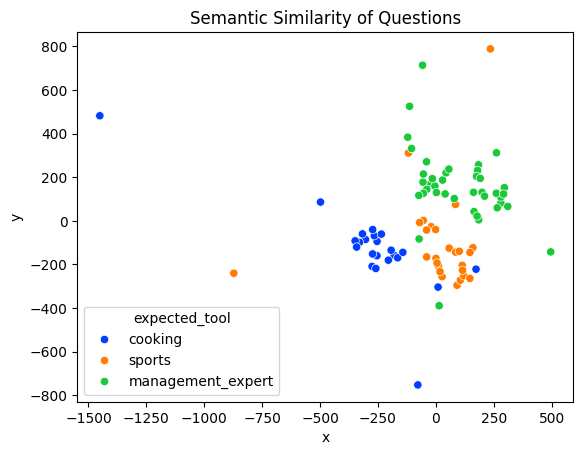

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


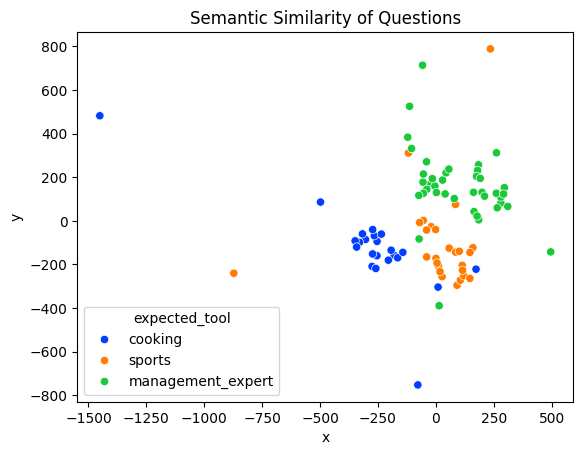

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


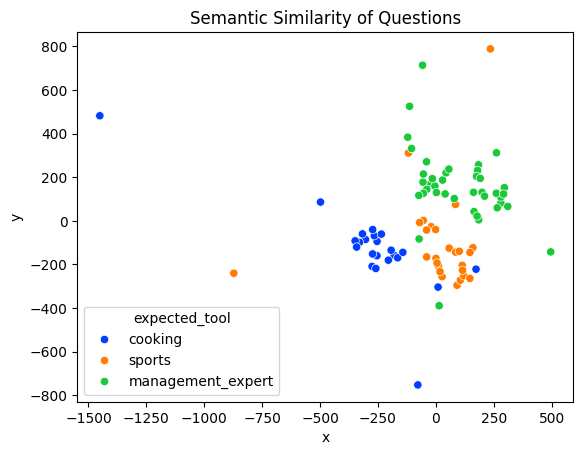

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


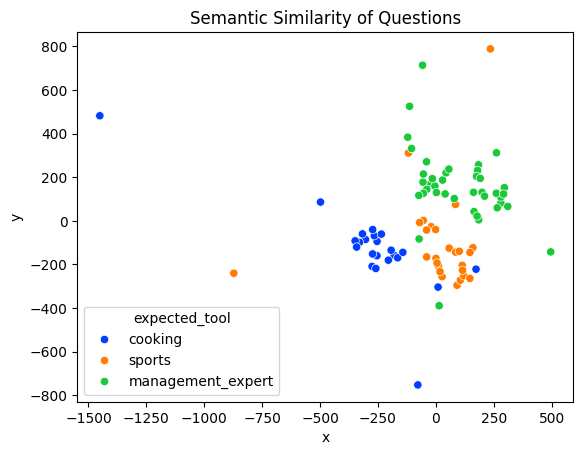

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


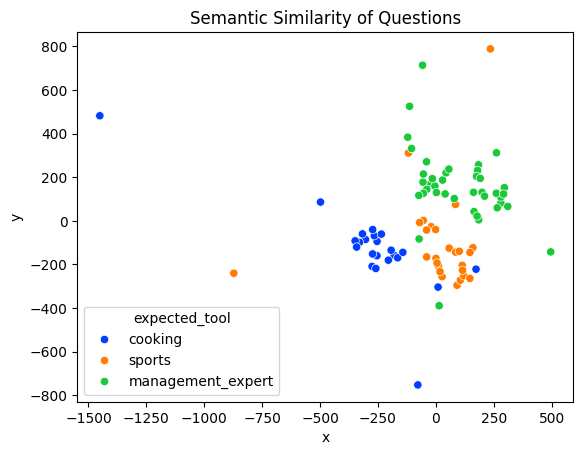

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


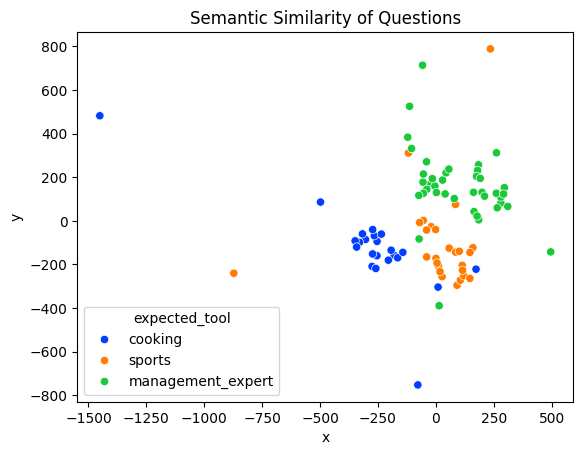

Semantic Router Incorrectly Routing How do you improve accuracy in archery? to management_expert (expected sports)
Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 0.8888888888888888
LLM Routing Accuracy: 1.0


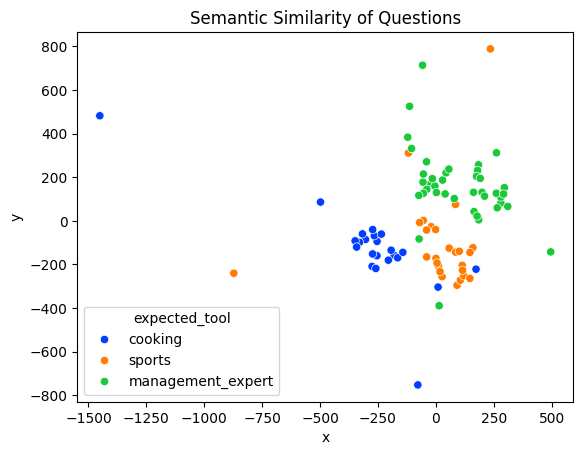

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


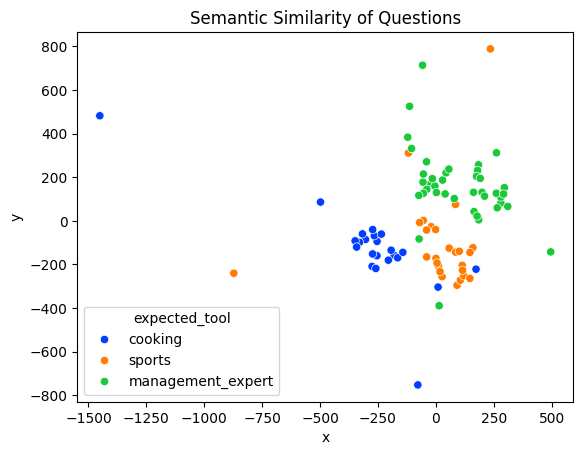

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


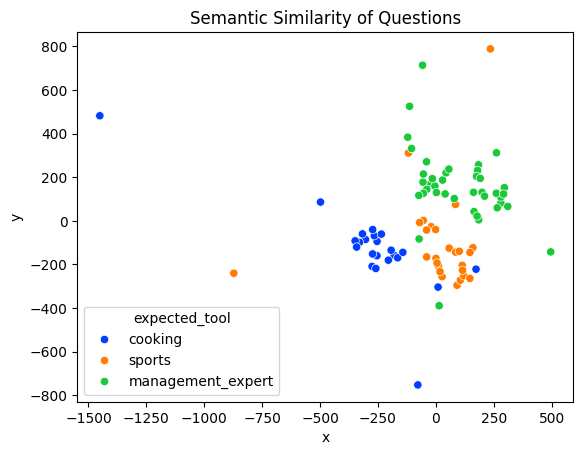

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0


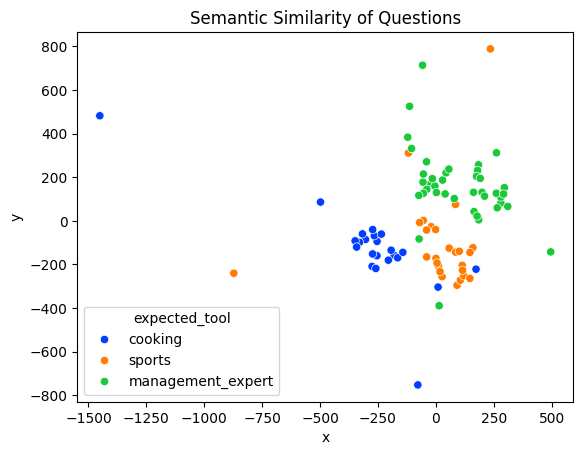

Silhouette Score: 0.13145038261933675
Davies Bouldin Index: 2.491967727345286
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 1.0
Davies Bouldin Index: 2.4919677273452865
Semantic Accuracy: 0.9888888888888889
LLM Accuracy: 1.0
Silhouette Score: 0.13145038261933675
Total Semantic Routing Time: 0.050307090303249424
Total LLM Routing Time: 13.166975215003186


In [19]:
aggregate_results = {
    'silhouette_score': [],
    'davies_bouldin_score': [],
    'semantic_accuracy': [],
    'llm_accuracy': [],
    'total_semantic_time': [],
    'total_llm_time': [],
    'timings': []
}

routes_subprompt = """
    cooking: Select this tool if the question is about cooking,
    sports: Select this tool if the question is about sports,
    management_expert: Select this tool if the question is about management of people in companies

    For example: What is the best way to cook a steak?
    Answer: cooking
"""



# we will do 10 experiments and average the results to try to avoid a little variability
for i in range(0,10):
    experiment_results = run_experiment(question_sets= question_sets_well_seperated, routes_subprompt = routes_subprompt, test_size = 3, nearest_neighbors_for_semantic_routing=2)
    aggregate_results['silhouette_score'].append(experiment_results['silhouette_score'])
    aggregate_results['davies_bouldin_score'].append(experiment_results['davis_bouldin_index'])
    aggregate_results['semantic_accuracy'].append(experiment_results['semantic_accuracy'])
    aggregate_results['llm_accuracy'].append(experiment_results['llm_accuracy'])
    aggregate_results['total_semantic_time'].append(experiment_results['total_semantic_time'])
    aggregate_results['total_llm_time'].append(experiment_results['total_llm_time'])
    aggregate_results['timings'].append(experiment_results['timings'])

Average_Silhouette_Score = sum(aggregate_results['silhouette_score']) / len(aggregate_results['silhouette_score'])
Average_davies_bouldin_score = sum(aggregate_results['davies_bouldin_score']) / len(aggregate_results['davies_bouldin_score'])
Average_Semantic_Accuracy = sum(aggregate_results['semantic_accuracy']) / len(aggregate_results['semantic_accuracy'])
Average_LLM_Accuracy = sum(aggregate_results['llm_accuracy']) / len(aggregate_results['llm_accuracy'])
Average_Total_Semantic_Time = sum(aggregate_results['total_semantic_time']) / len(aggregate_results['total_semantic_time'])
Average_Total_LLM_Time = sum(aggregate_results['total_llm_time']) / len(aggregate_results['total_llm_time'])

print(f"Davies Bouldin Index: {Average_davies_bouldin_score}")
print(f"Semantic Accuracy: {Average_Semantic_Accuracy}")
print(f"LLM Accuracy: {Average_LLM_Accuracy}")
print(f"Silhouette Score: {Average_Silhouette_Score}")
print(f"Total Semantic Routing Time: {Average_Total_Semantic_Time}")
print(f"Total LLM Routing Time: {Average_Total_LLM_Time}")


# Experiment 2: Not so Well Separated

/home/adam/.cache/pypoetry/virtualenvs/embeddings-as-tool-selectors-aC2G3cxR-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


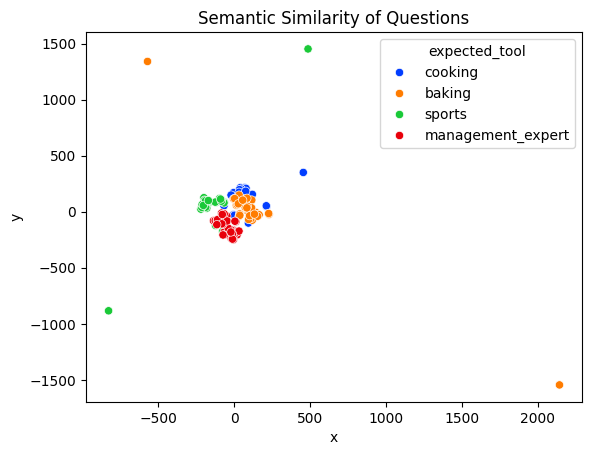

Semantic Router Incorrectly Routing I want to a make a dish to use up lots of black beans, how can I do this? to baking (expected cooking)
Semantic Router Incorrectly Routing What's the secret to making fluffy pancakes? to baking (expected cooking)
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.8333333333333334
LLM Routing Accuracy: 1.0


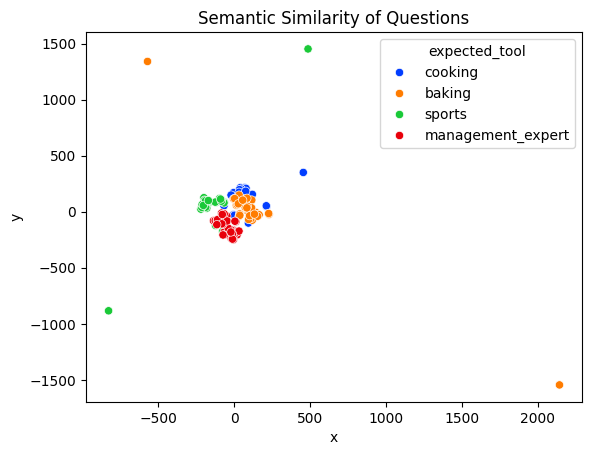

Semantic Router Incorrectly Routing How can you make a perfect emulsion for homemade mayonnaise? to baking (expected cooking)
Semantic Router Incorrectly Routing What's the difference between baking powder and baking soda in recipes? to baking (expected cooking)
LLM Router Incorrectly Routing What's the difference between baking powder and baking soda in recipes? to baking (expected cooking) for reason The best tool to choose for this question is baking. Baking powder and baking soda are commonly used ingredients in baking recipes. Baking powder is a combination of baking soda, cream of tartar, and a dry acid, while baking soda is pure sodium bicarbonate. Understanding the difference between the two and how they react in recipes is important for successful baking. Therefore, the baking tool is the most suitable option to answer this question.
LLM Router Incorrectly Routing What is the difference between baking soda and baking powder? to cooking (expected baking) for reason The best too

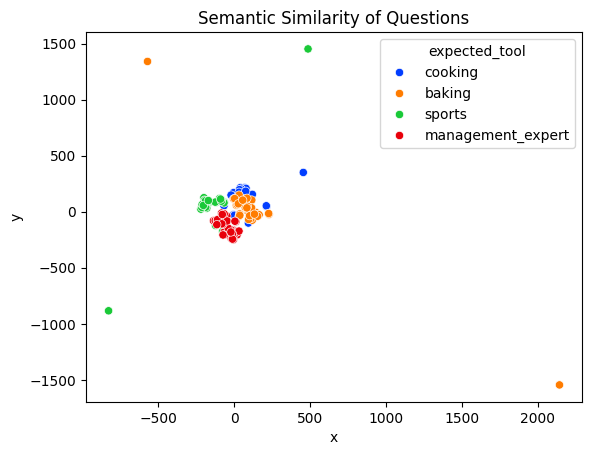

Semantic Router Incorrectly Routing How can I prevent pasta from sticking together while cooking? to baking (expected cooking)
Semantic Router Incorrectly Routing What are the health benefits of regular yoga practice? to management_expert (expected sports)
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.8333333333333334
LLM Routing Accuracy: 1.0


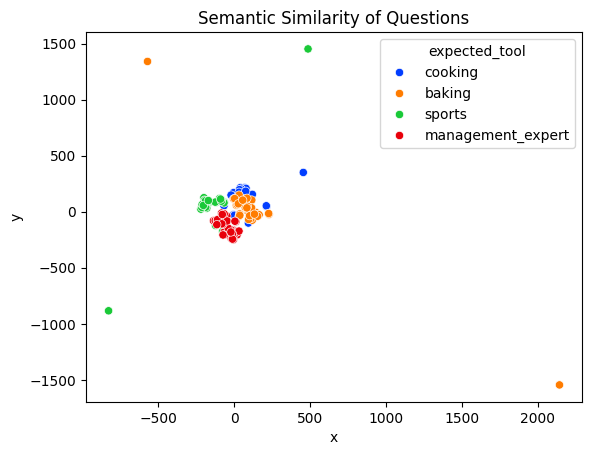

LLM Router Incorrectly Routing What is the difference between baking soda and baking powder? to cooking (expected baking) for reason The best tool to choose for this question is cooking because it is specifically related to the differences between baking soda and baking powder in the context of cooking and baking.
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 1.0
LLM Routing Accuracy: 0.9166666666666666


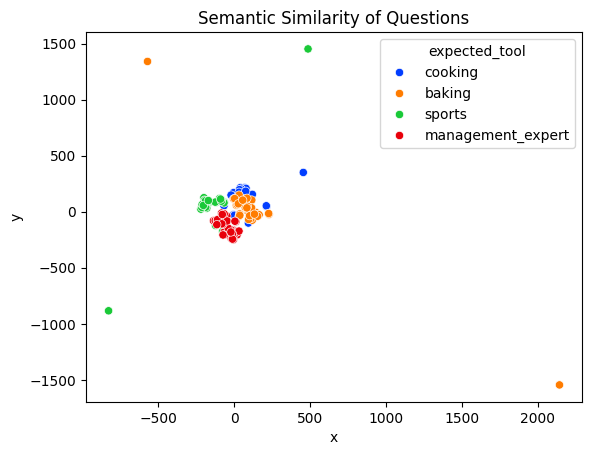

Semantic Router Incorrectly Routing How can you tell if eggs are still fresh? to baking (expected cooking)
LLM Router Incorrectly Routing What is the difference between baking soda and baking powder? to cooking (expected baking) for reason The best tool to choose for this question is cooking because it is specifically related to the difference between baking soda and baking powder in the context of cooking and baking.
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.9166666666666666
LLM Routing Accuracy: 0.9166666666666666


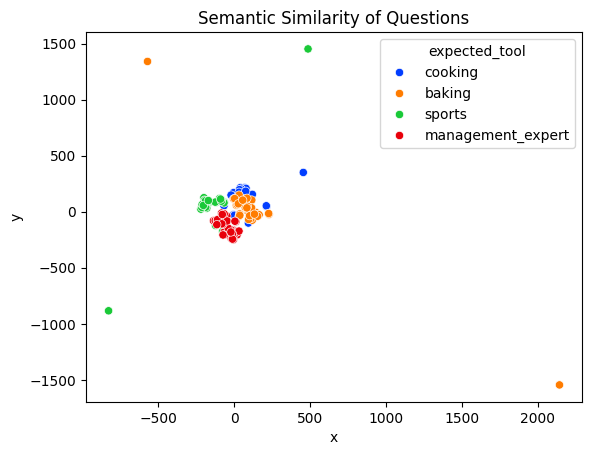

Semantic Router Incorrectly Routing How can I prevent pasta from sticking together while cooking? to baking (expected cooking)
Semantic Router Incorrectly Routing How do you properly season a cast iron skillet? to baking (expected cooking)
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.8333333333333334
LLM Routing Accuracy: 1.0


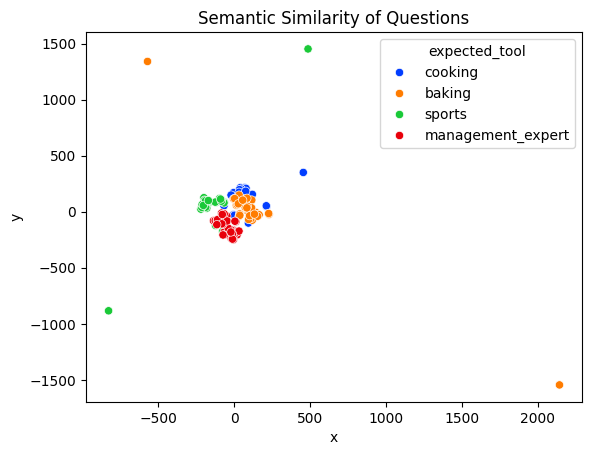

Semantic Router Incorrectly Routing What's the difference between simmering and boiling in cooking? to baking (expected cooking)
Semantic Router Incorrectly Routing What's the difference between baking powder and baking soda in recipes? to baking (expected cooking)
LLM Router Incorrectly Routing What's the difference between baking powder and baking soda in recipes? to baking (expected cooking) for reason The best tool to choose for this question is baking. Baking powder and baking soda are commonly used ingredients in baking recipes. Baking powder is a combination of baking soda, cream of tartar, and a dry acid, while baking soda is pure sodium bicarbonate. They both help to leaven baked goods, but they have different properties and are used in different ways. Baking powder is used when a recipe needs both a leavening agent and an acid, while baking soda is used when a recipe already has an acid present. Baking powder is also double-acting, meaning it reacts twice during the baking pr

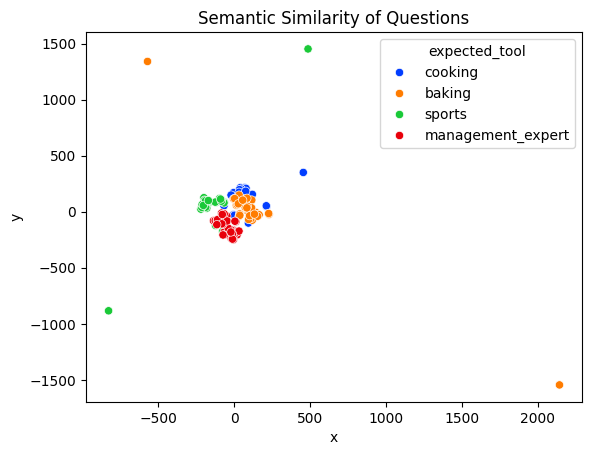

Semantic Router Incorrectly Routing How can I prevent pasta from sticking together while cooking? to baking (expected cooking)
Semantic Router Incorrectly Routing What's the secret to making fluffy pancakes? to baking (expected cooking)
Semantic Router Incorrectly Routing What is the difference between a marathon and a sprint? to cooking (expected sports)
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.75
LLM Routing Accuracy: 1.0


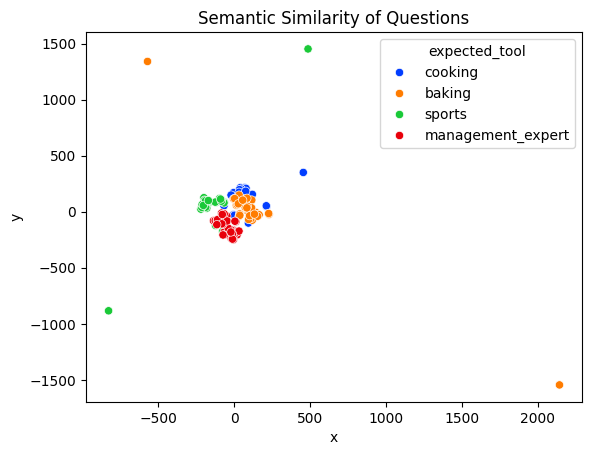

Semantic Router Incorrectly Routing How can I prevent pasta from sticking together while cooking? to baking (expected cooking)
Semantic Router Incorrectly Routing What are the key spices in a traditional Indian curry? to baking (expected cooking)
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.8333333333333334
LLM Routing Accuracy: 1.0


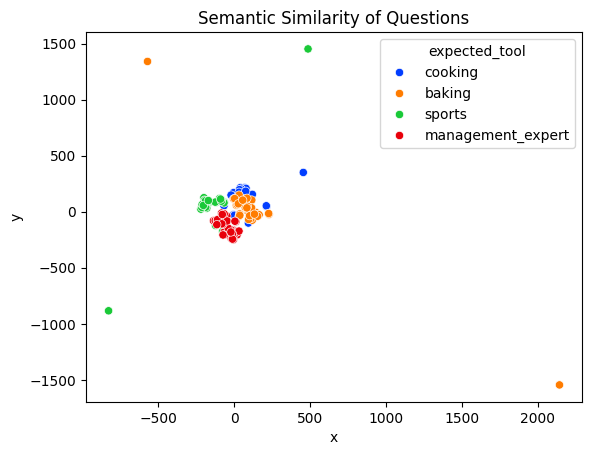

Semantic Router Incorrectly Routing What's the secret to making fluffy pancakes? to baking (expected cooking)
Semantic Router Incorrectly Routing I want to a make a dish to use up lots of black beans, how can I do this? to baking (expected cooking)
Semantic Router Incorrectly Routing How can you make a perfect emulsion for homemade mayonnaise? to baking (expected cooking)
Semantic Router Incorrectly Routing How do you improve accuracy in archery? to management_expert (expected sports)
Silhouette Score: 0.1117717172393854
Davies Bouldin Index: 2.781495635293483
Semantic Routing Accuracy: 0.6666666666666666
LLM Routing Accuracy: 1.0
Davies Bouldin Index: 2.7814956352934828
Semantic Accuracy: 0.8333333333333333
LLM Accuracy: 0.9583333333333334
Silhouette Score: 0.11177171723938542
Total Semantic Routing Time: 0.10094529339985456
Total LLM Routing Time: 19.30437645930069


In [20]:
aggregate_results = {
    'silhouette_score': [],
    'davies_bouldin_score': [],
    'semantic_accuracy': [],
    'llm_accuracy': [],
    'total_semantic_time': [],
    'total_llm_time': [],
    'timings': []
}

routes_subprompt = """
    cooking: Select this tool if the question is about cooking,
    baking: Select this tool if the question is about baking,
    sports: Select this tool if the question is about sports,
    management_expert: Select this tool if the question is about management of people in companies

    For example: What is the best way to cook a steak?
    Answer: cooking
"""

# we will do 10 experiments and average the results to try to avoid a little variability
for i in range(0,10):
    experiment_results = run_experiment(question_sets= question_sets, routes_subprompt = routes_subprompt, test_size = 3, nearest_neighbors_for_semantic_routing=2)
    aggregate_results['silhouette_score'].append(experiment_results['silhouette_score'])
    aggregate_results['davies_bouldin_score'].append(experiment_results['davis_bouldin_index'])
    aggregate_results['semantic_accuracy'].append(experiment_results['semantic_accuracy'])
    aggregate_results['llm_accuracy'].append(experiment_results['llm_accuracy'])
    aggregate_results['total_semantic_time'].append(experiment_results['total_semantic_time'])
    aggregate_results['total_llm_time'].append(experiment_results['total_llm_time'])
    aggregate_results['timings'].append(experiment_results['timings'])

Average_Silhouette_Score = sum(aggregate_results['silhouette_score']) / len(aggregate_results['silhouette_score'])
Average_davies_bouldin_score = sum(aggregate_results['davies_bouldin_score']) / len(aggregate_results['davies_bouldin_score'])
Average_Semantic_Accuracy = sum(aggregate_results['semantic_accuracy']) / len(aggregate_results['semantic_accuracy'])
Average_LLM_Accuracy = sum(aggregate_results['llm_accuracy']) / len(aggregate_results['llm_accuracy'])
Average_Total_Semantic_Time = sum(aggregate_results['total_semantic_time']) / len(aggregate_results['total_semantic_time'])
Average_Total_LLM_Time = sum(aggregate_results['total_llm_time']) / len(aggregate_results['total_llm_time'])

print(f"Davies Bouldin Index: {Average_davies_bouldin_score}")
print(f"Semantic Accuracy: {Average_Semantic_Accuracy}")
print(f"LLM Accuracy: {Average_LLM_Accuracy}")
print(f"Silhouette Score: {Average_Silhouette_Score}")
print(f"Total Semantic Routing Time: {Average_Total_Semantic_Time}")
print(f"Total LLM Routing Time: {Average_Total_LLM_Time}")


# Experiment 3: Four categories that all have similar semantic flavouring

/home/adam/.cache/pypoetry/virtualenvs/embeddings-as-tool-selectors-aC2G3cxR-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


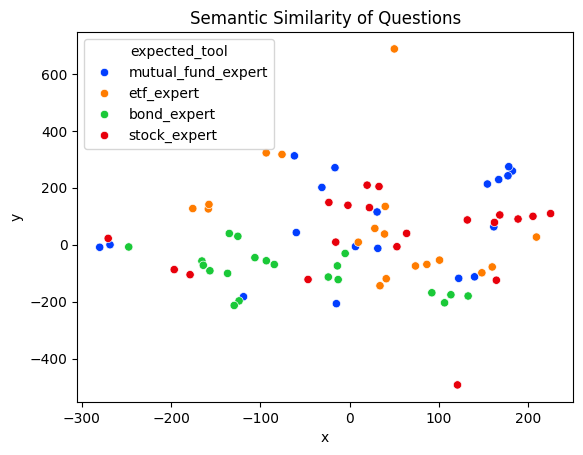

Semantic Router Incorrectly Routing What are sector mutual funds, and how do they differ from diversified funds? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing What is the significance of a mutual fund's NAV (Net Asset Value)? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing What is an IPO (Initial Public Offering) and how does it work? to bond_expert (expected stock_expert)
Semantic Router Incorrectly Routing What are growth stocks and how do they differ from value stocks? to bond_expert (expected stock_expert)
Silhouette Score: 0.10317807552530862
Davies Bouldin Index: 2.356764170512365
Semantic Routing Accuracy: 0.75
LLM Routing Accuracy: 1.0


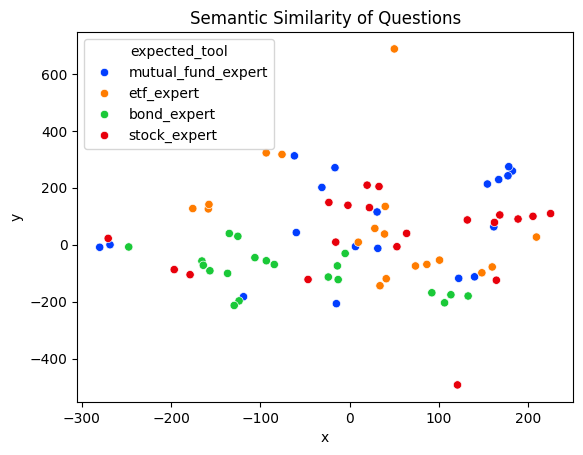

Semantic Router Incorrectly Routing What are sector mutual funds, and how do they differ from diversified funds? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing How do interest rates affect bond mutual funds? to bond_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing How does a mutual fund's expense ratio impact its returns? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing What are the risks of investing in penny stocks? to etf_expert (expected stock_expert)
Semantic Router Incorrectly Routing What factors should be considered when building a diversified stock portfolio? to bond_expert (expected stock_expert)
Semantic Router Incorrectly Routing What strategies are used for long-term stock investment? to mutual_fund_expert (expected stock_expert)
Silhouette Score: 0.10317807552530862
Davies Bouldin Index: 2.356764170512365
Semantic Routing Accuracy: 0.625
LLM Routing Accuracy: 1.0


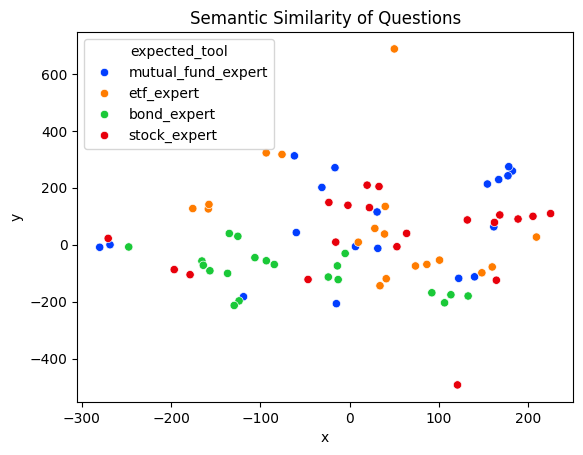

Semantic Router Incorrectly Routing How do mutual funds distribute dividends to investors? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing What are the advantages of buying bonds through a bond fund? to mutual_fund_expert (expected bond_expert)
Semantic Router Incorrectly Routing How do you evaluate the financial health of a stock? to etf_expert (expected stock_expert)
Semantic Router Incorrectly Routing How do dividend payments work for stock investors? to etf_expert (expected stock_expert)
Semantic Router Incorrectly Routing What strategies are used for long-term stock investment? to etf_expert (expected stock_expert)
Silhouette Score: 0.10317807552530862
Davies Bouldin Index: 2.356764170512365
Semantic Routing Accuracy: 0.6875
LLM Routing Accuracy: 1.0


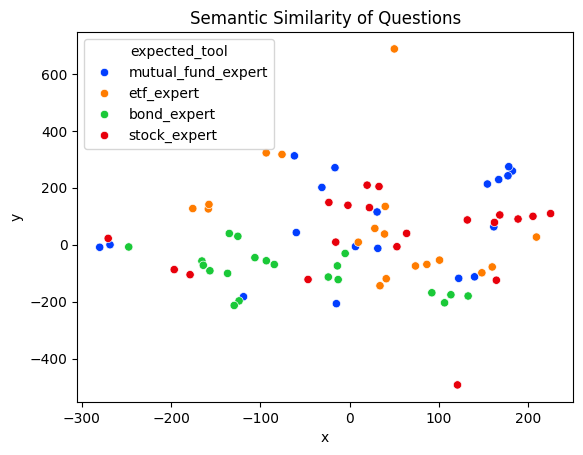

Semantic Router Incorrectly Routing How do mutual funds distribute dividends to investors? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing How do mutual funds diversify an investment portfolio? to bond_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing How does stock market volatility impact investors? to mutual_fund_expert (expected stock_expert)
Semantic Router Incorrectly Routing What factors should be considered when building a diversified stock portfolio? to bond_expert (expected stock_expert)
Semantic Router Incorrectly Routing What are the benefits of investing in blue-chip stocks? to mutual_fund_expert (expected stock_expert)
Silhouette Score: 0.10317807552530862
Davies Bouldin Index: 2.356764170512365
Semantic Routing Accuracy: 0.6875
LLM Routing Accuracy: 1.0


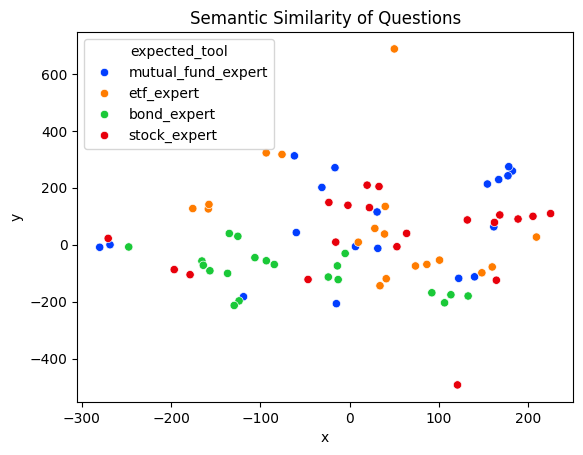

Semantic Router Incorrectly Routing What is the significance of a mutual fund's NAV (Net Asset Value)? to etf_expert (expected mutual_fund_expert)
Semantic Router Incorrectly Routing How do dividend distributions work with ETFs? to mutual_fund_expert (expected etf_expert)
Semantic Router Incorrectly Routing What are the benefits of investing in blue-chip stocks? to mutual_fund_expert (expected stock_expert)
Semantic Router Incorrectly Routing How does stock market volatility impact investors? to mutual_fund_expert (expected stock_expert)
Silhouette Score: 0.10317807552530862
Davies Bouldin Index: 2.356764170512365
Semantic Routing Accuracy: 0.75
LLM Routing Accuracy: 1.0
Davies Bouldin Index: 2.356764170512365
Semantic Accuracy: 0.7
LLM Accuracy: 1.0
Silhouette Score: 0.10317807552530862
Total Semantic Routing Time: 0.07323422161280177
Total LLM Routing Time: 30.798221429798286


In [21]:
aggregate_results = {
    'silhouette_score': [],
    'davies_bouldin_score': [],
    'semantic_accuracy': [],
    'llm_accuracy': [],
    'total_semantic_time': [],
    'total_llm_time': [],
    'timings': []
}

routes_subprompt = """
    etf_expert: Select this tool if the question is about ETFs. ETFs are financial instruments that track the performance of an index, commodity, or basket of assets.
    mutual_fund_expert: Select this tool if the question is about mutual funds. Mutual funds are financial instruments that pool money from many investors to purchase securities like stocks, bonds, and short-term debt.
    bond_expert: Select this tool if the question is about bonds. Bonds are financial instruments that represent a loan made by an investor to a borrower (typically corporate or governmental).
    stock_expert: Select this tool if the question is about stocks. Stocks are financial instruments that represent ownership in a company.

    For example:

    Question: How can you assess the liquidity of an ETF?
    Answer: etf_expert
"""

for i in range(0,5):
    experiment_results = run_experiment(question_sets=financial_question_set,routes_subprompt=routes_subprompt, test_size = 4, nearest_neighbors_for_semantic_routing=2)
    aggregate_results['silhouette_score'].append(experiment_results['silhouette_score'])
    aggregate_results['davies_bouldin_score'].append(experiment_results['davis_bouldin_index'])
    aggregate_results['semantic_accuracy'].append(experiment_results['semantic_accuracy'])
    aggregate_results['llm_accuracy'].append(experiment_results['llm_accuracy'])
    aggregate_results['total_semantic_time'].append(experiment_results['total_semantic_time'])
    aggregate_results['total_llm_time'].append(experiment_results['total_llm_time'])
    aggregate_results['timings'].append(experiment_results['timings'])

Average_Silhouette_Score = sum(aggregate_results['silhouette_score']) / len(aggregate_results['silhouette_score'])
Average_davies_bouldin_score = sum(aggregate_results['davies_bouldin_score']) / len(aggregate_results['davies_bouldin_score'])
Average_Semantic_Accuracy = sum(aggregate_results['semantic_accuracy']) / len(aggregate_results['semantic_accuracy'])
Average_LLM_Accuracy = sum(aggregate_results['llm_accuracy']) / len(aggregate_results['llm_accuracy'])
Average_Total_Semantic_Time = sum(aggregate_results['total_semantic_time']) / len(aggregate_results['total_semantic_time'])
Average_Total_LLM_Time = sum(aggregate_results['total_llm_time']) / len(aggregate_results['total_llm_time'])

print(f"Davies Bouldin Index: {Average_davies_bouldin_score}")
print(f"Semantic Accuracy: {Average_Semantic_Accuracy}")
print(f"LLM Accuracy: {Average_LLM_Accuracy}")
print(f"Silhouette Score: {Average_Silhouette_Score}")
print(f"Total Semantic Routing Time: {Average_Total_Semantic_Time}")
print(f"Total LLM Routing Time: {Average_Total_LLM_Time}")


# 

In [19]:
Average_Silhouette_Score = sum(aggregate_results['silhouette_score']) / len(aggregate_results['silhouette_score'])
Average_davies_bouldin_score = sum(aggregate_results['davies_bouldin_score']) / len(aggregate_results['davies_bouldin_score'])
Average_Semantic_Accuracy = sum(aggregate_results['semantic_accuracy']) / len(aggregate_results['semantic_accuracy'])
Average_LLM_Accuracy = sum(aggregate_results['llm_accuracy']) / len(aggregate_results['llm_accuracy'])
Average_Total_Semantic_Time = sum(aggregate_results['total_semantic_time']) / len(aggregate_results['total_semantic_time'])
Average_Total_LLM_Time = sum(aggregate_results['total_llm_time']) / len(aggregate_results['total_llm_time'])

print(f"Davies Bouldin Index: {Average_davies_bouldin_score}")
print(f"Semantic Accuracy: {Average_Semantic_Accuracy}")
print(f"LLM Accuracy: {Average_LLM_Accuracy}")
print(f"Silhouette Score: {Average_Silhouette_Score}")
print(f"Total Semantic Routing Time: {Average_Total_Semantic_Time}")
print(f"Total LLM Routing Time: {Average_Total_LLM_Time}")



Davies Bouldin Index: 2.356748278511514
Semantic Accuracy: 0.6875
LLM Accuracy: 1.0
Silhouette Score: 0.10316128208012186
Total Semantic Routing Time: 0.063590107994969
Total LLM Routing Time: 29.16909711100743


# Experiment 4: Big Data Set

This might juice your credit card, be careful

/home/adam/.cache/pypoetry/virtualenvs/embeddings-as-tool-selectors-aC2G3cxR-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


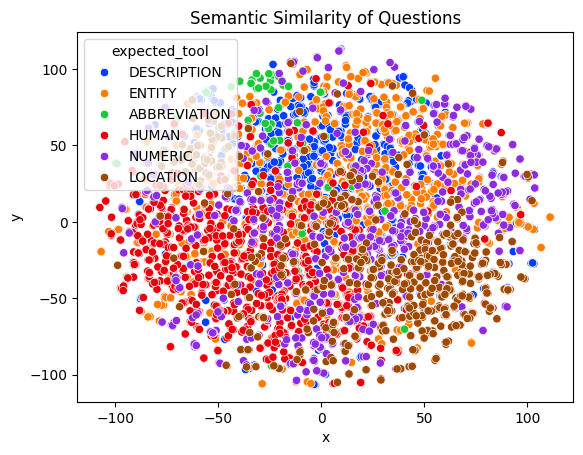

Semantic Router Incorrectly Routing Where do chihuahuas come from ? to LOCATION (expected DESCRIPTION)
Semantic Router Incorrectly Routing What is the meaning of `` CPR '' ? to ABBREVIATION (expected DESCRIPTION)
Semantic Router Incorrectly Routing What is federal income tax ? to NUMERIC (expected DESCRIPTION)
Semantic Router Incorrectly Routing What is the origin of the term `` The Brooklyn Side '' in bowling ? to HUMAN (expected DESCRIPTION)
Semantic Router Incorrectly Routing Why are the ears your center of balance ? to ENTITY (expected DESCRIPTION)
Semantic Router Incorrectly Routing What 's the rathaus in Frankfurt ? to LOCATION (expected DESCRIPTION)
Semantic Router Incorrectly Routing Why was Muhammad Ali stripped of his title and barred from boxing in 1967 ? to HUMAN (expected DESCRIPTION)
Semantic Router Incorrectly Routing What was a California prayer book to an Old West gambler ? to HUMAN (expected ENTITY)
Semantic Router Incorrectly Routing What killed Bob Marley ? to DESCR

In [21]:
# Build a question set from this dataset

df = pd.read_csv("Question_Classification_Dataset.csv")

question_classification_question_sets = []

for category in df['Category0'].unique():
    question_classification_question_sets.append({
        'expected_tool': category,
        'questions': df[df['Category0'] == category]['Questions'].to_list()
    })

# Run Experiment
aggregate_results = {
    'silhouette_score': [],
    'davies_bouldin_score': [], 
    'semantic_accuracy': [],
    'llm_accuracy': [],
    'total_semantic_time': [],
    'total_llm_time': [],
    'timings': []
}

routes_subprompt = """
    You should select one of these tools based on what the answer to the QUESTION should look like.

    ABBREVIATION: This tootool provides answers that arevides answers that explain the meaning of abbreviations, acronyms, etc.
    DESCRIPTION: This tool provides answers in the form of a description
    ENTITY: This tool provides answers that are animals, colors, events, food, etc.
    HUMAN: The tool provides answers that are a group or organization of persons, an individual, etc.
    NUMERIC: This tool provides answers that are a numeric like postcodes, dates, speed,temperature, etc
    LOCATION: The tool provides answers that are a location. a place, a country, city, etc.
"""

experiment_results = run_experiment(question_sets=question_classification_question_sets,routes_subprompt=routes_subprompt , test_size = 20, nearest_neighbors_for_semantic_routing=1)
aggregate_results['silhouette_score'].append(experiment_results['silhouette_score'])
aggregate_results['davies_bouldin_score'].append(experiment_results['davis_bouldin_index'])
aggregate_results['semantic_accuracy'].append(experiment_results['semantic_accuracy'])
aggregate_results['llm_accuracy'].append(experiment_results['llm_accuracy'])
aggregate_results['total_semantic_time'].append(experiment_results['total_semantic_time'])
aggregate_results['total_llm_time'].append(experiment_results['total_llm_time'])
aggregate_results['timings'].append(experiment_results['timings'])
# Print out results
Average_Silhouette_Score = sum(aggregate_results['silhouette_score']) / len(aggregate_results['silhouette_score'])
Average_Semantic_Accuracy = sum(aggregate_results['semantic_accuracy']) / len(aggregate_results['semantic_accuracy'])
Average_LLM_Accuracy = sum(aggregate_results['llm_accuracy']) / len(aggregate_results['llm_accuracy'])
Average_Total_Semantic_Time = sum(aggregate_results['total_semantic_time']) / len(aggregate_results['total_semantic_time'])
Average_Total_LLM_Time = sum(aggregate_results['total_llm_time']) / len(aggregate_results['total_llm_time'])

print(f"Semantic Accuracy: {Average_Semantic_Accuracy}")
print(f"LLM Accuracy: {Average_LLM_Accuracy}")
print(f"Silhouette Score: {Average_Silhouette_Score}")
print(f"Total Semantic Routing Time: {Average_Total_Semantic_Time}")
print(f"Total LLM Routing Time: {Average_Total_LLM_Time}")



In [ ]:
len(hash_to_embeddings)